# H-calls4fam_TFDS_rnn


In [1]:
# @title
import datetime
print(datetime.datetime.now())

2024-05-05 13:51:16.802527


Similar to the example we demonstrate in the class, here are some samples of malware call sequences.

Now you need to use RNN to analysis the call sequences.

In [2]:
import os
import pandas as pd
import numpy as np

## tfds Data

In [3]:
# TFDS
name = "calls4fam_0522"

save_dir = "./" + name + "/"

In [4]:
# get data from github

import requests

url = 'https://github.com/hsiaom26/DS4CS-24/raw/main/data/calls4fam_0522_tfds.tgz'

response = requests.get(url)

if response.status_code == 200:
    # Open the file for writing
    with open('calls4fam_0522_tfds.tgz', 'wb') as f:
        # Write the response content to the file
        f.write(response.content)
else:
    print('Error: Failed to download the file')

In [5]:
!tar -zxvf calls4fam_0522_tfds.tgz

./calls4fam_0522/
./calls4fam_0522/2/
./calls4fam_0522/2/626.txt
./calls4fam_0522/2/834.txt
./calls4fam_0522/2/751.txt
./calls4fam_0522/2/866.txt
./calls4fam_0522/2/735.txt
./calls4fam_0522/2/850.txt
./calls4fam_0522/2/808.txt
./calls4fam_0522/2/847.txt
./calls4fam_0522/2/661.txt
./calls4fam_0522/2/809.txt
./calls4fam_0522/2/686.txt
./calls4fam_0522/2/638.txt
./calls4fam_0522/2/774.txt
./calls4fam_0522/2/758.txt
./calls4fam_0522/2/791.txt
./calls4fam_0522/2/631.txt
./calls4fam_0522/2/854.txt
./calls4fam_0522/2/629.txt
./calls4fam_0522/2/616.txt
./calls4fam_0522/2/889.txt
./calls4fam_0522/2/617.txt
./calls4fam_0522/2/902.txt
./calls4fam_0522/2/772.txt
./calls4fam_0522/2/837.txt
./calls4fam_0522/2/623.txt
./calls4fam_0522/2/815.txt
./calls4fam_0522/2/822.txt
./calls4fam_0522/2/648.txt
./calls4fam_0522/2/768.txt
./calls4fam_0522/2/884.txt
./calls4fam_0522/2/694.txt
./calls4fam_0522/2/745.txt
./calls4fam_0522/2/769.txt
./calls4fam_0522/2/839.txt
./calls4fam_0522/2/784.txt
./calls4fam_0522/

In [6]:
!ls -al calls4fam_0522

total 56
drwxr-xr-x 6 root root  4096 Feb 21 04:06 .
drwxr-xr-x 1 root root  4096 May  5 13:51 ..
drwxr-xr-x 2 root root 12288 Feb 21 04:06 0
drwxr-xr-x 2 root root 12288 Feb 21 04:06 1
drwxr-xr-x 2 root root 12288 Feb 21 04:06 2
drwxr-xr-x 2 root root 12288 Feb 21 04:06 5


### Transform to tf.Data by utils.text_dataset_from_directory

In [7]:
import tensorflow as tf
from tensorflow.keras import utils
import tensorflow_datasets as tfds

In [8]:
batch_size = 32
seed = 42

train_dataset = utils.text_dataset_from_directory(
    save_dir, # from unziped dir
    labels = "inferred", # labels are generated from the directory structure
    label_mode = "int", # for sparse_categorical_crossentropy loss
    batch_size = batch_size,
    shuffle = True,
    seed = seed,
    validation_split = 0.2,
    subset = 'training', # or 'validation' to get the val dataset
    )

Found 1208 files belonging to 4 classes.
Using 967 files for training.


In [9]:
val_dataset = utils.text_dataset_from_directory(
    save_dir,
    labels = "inferred",
    label_mode = "int",
    batch_size = batch_size,
    shuffle = True,
    seed = seed,
    validation_split = 0.2,
    subset = 'validation', # <----
    )

Found 1208 files belonging to 4 classes.
Using 241 files for validation.


In [10]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
for example, label in train_dataset.take(1): # take 1 batch_size
  for i in range(3): # print first 3
    print('label: ', label[i].numpy())
    print('text: ', example[i].numpy())

label:  1
text:  b'rt_sigaction rt_sigaction rt_sigprocmask execve brk access access openat fstat mmap close access openat read fstat mmap mmap mprotect mmap mmap close arch_prctl mprotect mprotect mprotect munmap getuid getgid getpid rt_sigaction geteuid brk brk getppid stat stat geteuid getegid rt_sigaction rt_sigaction rt_sigaction rt_sigaction stat stat stat stat stat stat clone wait4 SIGCHLD rt_sigreturn exit_group'
label:  1
text:  b'getpid ugetrlimit rt_sigaction rt_sigaction rt_sigprocmask getpid ugetrlimit rt_sigaction rt_sigaction rt_sigaction execve brk access access openat fstat mmap close access openat read fstat mmap mmap mprotect mmap mmap close arch_prctl mprotect mprotect mprotect munmap getuid getgid getpid rt_sigaction geteuid brk brk getppid stat stat geteuid getegid rt_sigaction rt_sigaction rt_sigaction rt_sigaction stat stat stat stat stat stat clone wait4 SIGCHLD rt_sigreturn exit_group'
label:  3
text:  b'dup2 close execve brk access access openat fstat mmap cl

In [12]:
# vocab size
vocab_set = set()
separator = ' '

# classes
class_set = set()

In [13]:
for text_batch, label_batch in train_dataset:
  for idx in range(len(text_batch)):
    # text
    line = text_batch.numpy()[idx]
    line = line.decode("utf-8")
    tokens = line.split(separator)
    for token in tokens:
      vocab_set.add(token)

    # label
    class_set.add(int(label_batch.numpy()[idx]))


print(len(vocab_set))
print(len(class_set))

121
4


### RNN

Same as
https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [14]:
# RNN

BATCH_SIZE = batch_size # same as TFDS
VOCAB_SIZE = len(vocab_set) + 2 # one for "", one for [UNK]

num_class = len(class_set)

In [15]:
encoder = tf.keras.layers.TextVectorization(max_tokens = VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [16]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'sendto', 'read', 'close', 'recvfrom', 'rtsigaction',
       'nanosleep', 'open', 'rtsigprocmask', 'mmap2', 'fstat64',
       'connect', 'mmap', 'munmap', 'mprotect', 'time', 'gettimeofday',
       'setsockopt', 'access'], dtype='<U17')

In [17]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 6,  6,  9, ...,  0,  0,  0],
       [37, 77,  6, ...,  0,  0,  0],
       [57,  4, 30, ...,  0,  0,  0]])

In [18]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'rt_sigaction rt_sigaction rt_sigprocmask execve brk access access openat fstat mmap close access openat read fstat mmap mmap mprotect mmap mmap close arch_prctl mprotect mprotect mprotect munmap getuid getgid getpid rt_sigaction geteuid brk brk getppid stat stat geteuid getegid rt_sigaction rt_sigaction rt_sigaction rt_sigaction stat stat stat stat stat stat clone wait4 SIGCHLD rt_sigreturn exit_group'
Round-trip:  rtsigaction rtsigaction rtsigprocmask execve brk access access openat fstat mmap close access openat read fstat mmap mmap mprotect mmap mmap close archprctl mprotect mprotect mprotect munmap getuid getgid getpid rtsigaction geteuid brk brk getppid stat stat geteuid getegid rtsigaction rtsigaction rtsigaction rtsigaction stat stat stat stat stat stat clone wait4 sigchld rtsigreturn exitgroup                                                                                                                                                                               

In [24]:
# model = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(
#         input_dim = len(encoder.get_vocabulary()),
#         output_dim = 64,
#         # Use masking to handle the variable sequence lengths
#         mask_zero = True),
#     # Now, try to design your RNN
#     # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # complex nn
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # 64, change to 32 if complex nn used
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.5), # complex nn
#     tf.keras.layers.Dense(num_class, activation='softmax') # from_logits=False, SparseCategoricalCrossentropy
# ])

#修改後的model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_class, activation='softmax')
])


In [25]:
# print your model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          7872      
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                      

In [26]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True, True]


In [27]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [28]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, # isn't it cheating?
                    )

Epoch 1/10
31/31 [==============================] - 32s 549ms/step - loss: 1.3768 - accuracy: 0.4778 - val_loss: 1.3627 - val_accuracy: 0.6598
Epoch 2/10
31/31 [==============================] - 11s 352ms/step - loss: 1.3441 - accuracy: 0.6505 - val_loss: 1.3078 - val_accuracy: 0.6473
Epoch 3/10
31/31 [==============================] - 11s 366ms/step - loss: 1.2161 - accuracy: 0.6453 - val_loss: 1.0674 - val_accuracy: 0.4689
Epoch 4/10
31/31 [==============================] - 11s 354ms/step - loss: 0.9600 - accuracy: 0.6339 - val_loss: 0.7734 - val_accuracy: 0.6349
Epoch 5/10
31/31 [==============================] - 10s 329ms/step - loss: 0.6818 - accuracy: 0.6680 - val_loss: 0.5842 - val_accuracy: 0.7220
Epoch 6/10
31/31 [==============================] - 10s 330ms/step - loss: 0.5941 - accuracy: 0.6867 - val_loss: 0.5291 - val_accuracy: 0.7635
Epoch 7/10
31/31 [==============================] - 11s 347ms/step - loss: 0.5539 - accuracy: 0.7084 - val_loss: 0.4804 - val_accuracy: 0.7593

In [29]:
# use val_dataset as testing dataset
test_loss, test_acc = model.evaluate(val_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 167ms/step - loss: 0.4226 - accuracy: 0.8465
Test Loss: 0.4226294457912445
Test Accuracy: 0.8464730381965637


In [30]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

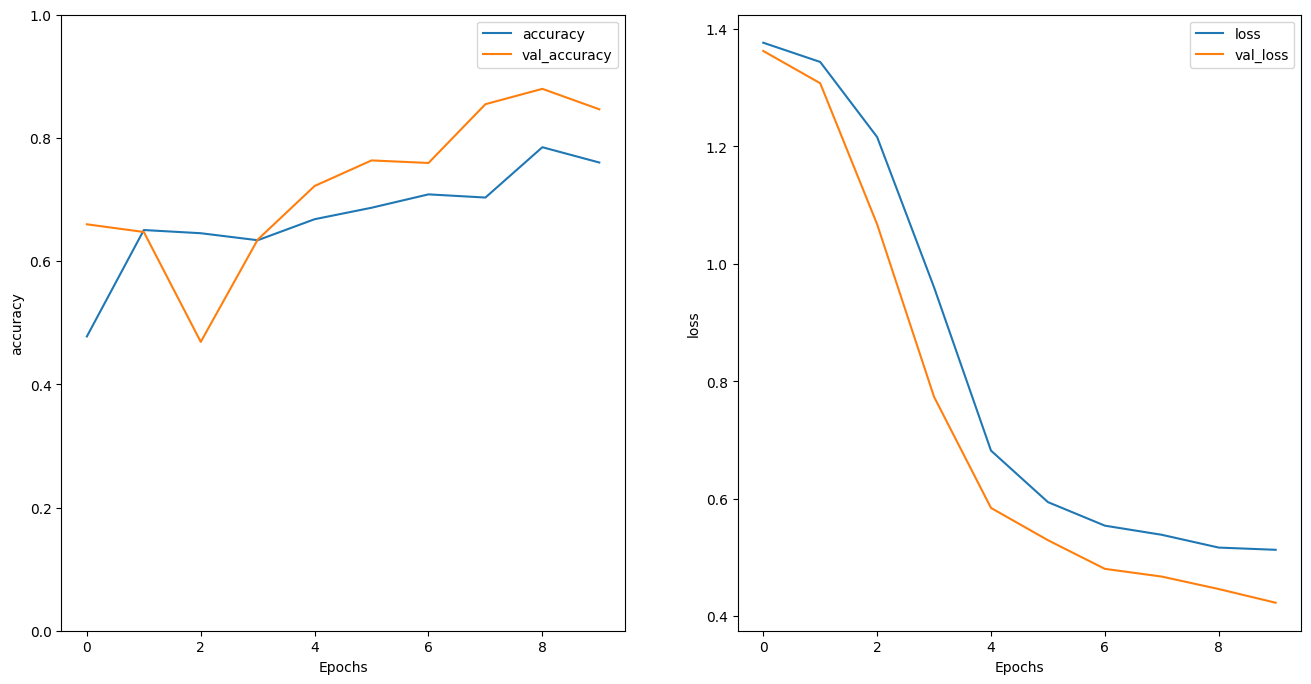

In [31]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(0.0, 1.0)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

#Question

## Q1

Change the rnn structure and make the accuracy better.

修改後的模型在上面

### Q1-1

Show your model summary.

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          7872      
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                      

### Q1-2

Show your confusion matrix.

1/1 [==============================] - 4s 4s/step


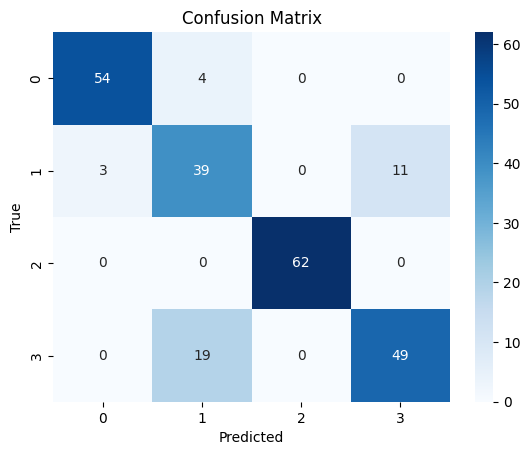

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = []
y_true = []
for text, labels in val_dataset:
    predictions = model.predict(text)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())


cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Q2

Try to use one-hot encoding and a dense neural network to classify the same dataset.

In [ ]:
def count_api_calls(malware_text_file):
  aip_dict = dict()
  with open(malware_text_file, 'r') as file:
    call_seq = file.readline() # note: only one line in .txt file
    calls = call_seq.split()
    for call in calls:
      if call in aip_dict:
        aip_dict[call] += 1
      else:
        aip_dict[call] = 1
    return aip_dict

In [ ]:
import os

malware_call_dict = dict()

root_dir = "/content/calls4fam_0522/"
for dir_name, subdir_list, file_list in os.walk(root_dir):


    for file_name in file_list:
        if file_name.endswith(".txt"):
            subdir = dir_name.split('/')[-1]
            malware_call_dict[subdir+'/'+file_name] = count_api_calls(os.path.join(dir_name, file_name))

In [ ]:
import pandas as pd

malware_call_df = pd.DataFrame.from_dict(malware_call_dict, orient='index')
malware_call_df.fillna(0, inplace=True)
malware_call_df

,rt_sigaction,execve,brk,access,openat,fstat,mmap,close,read,mprotect,...,prctl,sched_setscheduler,symlinkat,mkdir,rmdir,ftruncate,getdents64,unlink,kill,accept
5/1057.txt,10.0,1.0,3.0,3.0,3.0,2.0,5.0,5.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5/1016.txt,10.0,1.0,3.0,3.0,2.0,2.0,5.0,2.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5/1136.txt,10.0,1.0,3.0,3.0,3.0,2.0,5.0,5.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5/1165.txt,2.0,1.0,3.0,6.0,8.0,10.0,15.0,12.0,6.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5/1090.txt,10.0,1.0,3.0,3.0,3.0,2.0,5.0,5.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1/505.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/398.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/580.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/418.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


X_data = malware_call_df.values

labels = malware_call_df.index.str.split('/').str[0].astype(int)

labels

Index([5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       ...
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1],
      dtype='int64', length=1208)

In [ ]:
y_encoded = to_categorical(labels)
y_encoded

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X_data, y_encoded, test_size=0.2, random_state=0)

# CNN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.1)

test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print('Test accuracy:', test_acc)


Epoch 1/10
28/28 [==============================] - 1s 9ms/step - loss: 2.5485 - accuracy: 0.6180 - val_loss: 0.6830 - val_accuracy: 0.7526
Epoch 2/10
28/28 [==============================] - 0s 4ms/step - loss: 0.5999 - accuracy: 0.8308 - val_loss: 0.4728 - val_accuracy: 0.8041
Epoch 3/10
28/28 [==============================] - 0s 4ms/step - loss: 0.4182 - accuracy: 0.8953 - val_loss: 0.3084 - val_accuracy: 0.9072
Epoch 4/10
28/28 [==============================] - 0s 4ms/step - loss: 0.2835 - accuracy: 0.9287 - val_loss: 0.2698 - val_accuracy: 0.9072
Epoch 5/10
28/28 [==============================] - 0s 4ms/step - loss: 0.2375 - accuracy: 0.9459 - val_loss: 0.2274 - val_accuracy: 0.9588
Epoch 6/10
28/28 [==============================] - 0s 4ms/step - loss: 0.2102 - accuracy: 0.9528 - val_loss: 0.2006 - val_accuracy: 0.9588
Epoch 7/10
28/28 [==============================] - 0s 5ms/step - loss: 0.1786 - accuracy: 0.9655 - val_loss: 0.1796 - val_accuracy: 0.9794
Epoch 8/10
28/28 [==

###Q2-1

Show your model summary.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               15616     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 24262 (94.77 KB)
Trainable params: 24262 (94.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


###Q2-2

Show the confusion matrix of one-hot dense mdoel.


8/8 [==============================] - 0s 2ms/step


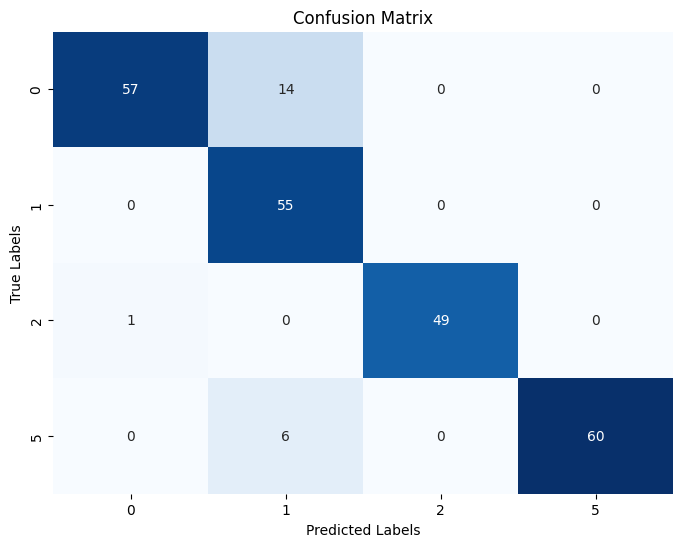

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_encoded, axis=1)

class_labels = [0, 1, 2, 5]

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels, labels=class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##Q3



###Q3-1

Which model performs better? Why?

CNN 在預測的準確率較高。CNN在處理具有局部結構的數據時表現良好，而上面call_f_fam的資料及可能剛好有這樣的特性。如果資料中的局部特徵存在關聯性，CNN能夠比較容易捕捉到這些訊息，如此造成CNN的準確率較高。

###Q3-2

If you extend the input size of RNN, will the acc increase? Or there should be a sweet spot of the length?

如果我們增加RNN 的input size，模型準確率不一定會提高。例如RNN有記憶的限制，所以可能在處理long sequence時會有一些問題。另外如果input size變得太大，可能會失去上下文，或是在訓練期間遇到梯度消失或爆炸的問題。最後，input size太大也有可能造成over fitting的問題。

###Q3-3

If you use one-hot two-gram or one-hot three-gram, will the dense model become better?

One-hot two-gram 或 one-hot three-gram會有一些優缺點，優點有以下：
1. 能有效節省記憶體以及增快計算的效率，特別是在處理處理大型詞彙或高維的數據時
2. 每個二元組或三元組的表示是獨立的，也可以簡化模型學習的過程。因為可以專注於識別個別二元組或三元組的關聯，而不需考慮它們的上下文關係。

缺點有以下：
1. one-hot encoding會失去原本的sequence，忽略了原始文本中單詞的順序或是上下文關係。假如原本的資料有上下文之間的關係會無法觀察到。
2. one-hot encoding會造成維度大幅提升，可能造成數據更為稀疏。需要對模型做調整才能更好避免over fitting。